In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import pandas as pd

# --- Dataset Path ---
base_dir = "/kaggle/input/coffee-beans-saad"

# --- Create DataFrame ---
def create_dataframe(data_dir):
    file_paths, labels = [], []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, img_name))
            labels.append(class_name)
    return pd.DataFrame({"file_path": file_paths, "label": labels})

train_df = create_dataframe(os.path.join(base_dir, "train"))
test_df = create_dataframe(os.path.join(base_dir, "test"))

# --- Transforms ---
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# --- Dataset Class ---
class CoffeeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(dataframe['label'].unique()))}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        label = self.label_to_idx[self.dataframe.iloc[idx]['label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = CoffeeDataset(train_df, transform=train_transforms)
test_dataset = CoffeeDataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [2]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*14*14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CustomCNN().to(device)


In [3]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/total:.4f}, Accuracy: {correct/total:.4f}")


Epoch 1/10 - Loss: 0.8864, Accuracy: 0.7050
Epoch 2/10 - Loss: 0.2330, Accuracy: 0.9100
Epoch 3/10 - Loss: 0.1241, Accuracy: 0.9583
Epoch 4/10 - Loss: 0.1037, Accuracy: 0.9642
Epoch 5/10 - Loss: 0.1248, Accuracy: 0.9550
Epoch 6/10 - Loss: 0.1126, Accuracy: 0.9625
Epoch 7/10 - Loss: 0.0632, Accuracy: 0.9775
Epoch 8/10 - Loss: 0.0360, Accuracy: 0.9858
Epoch 9/10 - Loss: 0.0324, Accuracy: 0.9892
Epoch 10/10 - Loss: 0.0308, Accuracy: 0.9908


In [4]:
import numpy as np

# Use CNN as feature extractor
feature_extractor = nn.Sequential(*list(model.features.children())).to(device)
feature_extractor.eval()

def extract_features(loader):
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            feats = feature_extractor(imgs)
            feats = feats.view(feats.size(0), -1).cpu().numpy()
            features.append(feats)
            labels.append(lbls.numpy())
    return np.vstack(features), np.hstack(labels)

X_train, y_train = extract_features(train_loader)
X_test, y_test = extract_features(test_loader)
print("Feature shape:", X_train.shape)


Feature shape: (1200, 50176)


In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# Train SVM
svm = SVC(kernel='rbf', probability=True)
start_train = time.time()
svm.fit(X_train, y_train)
end_train = time.time()

# Predict
start_test = time.time()
y_pred = svm.predict(X_test)
end_test = time.time()

# Metrics
print(f"Training Time: {end_train - start_train:.2f} sec")
print(f"Testing Time: {end_test - start_test:.2f} sec")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Training Time: 50.32 sec
Testing Time: 9.34 sec
Accuracy: 0.9950

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9800    0.9899       100
           1     1.0000    1.0000    1.0000       100
           2     1.0000    1.0000    1.0000       100
           3     0.9804    1.0000    0.9901       100

    accuracy                         0.9950       400
   macro avg     0.9951    0.9950    0.9950       400
weighted avg     0.9951    0.9950    0.9950       400

Confusion Matrix:
 [[ 98   0   0   2]
 [  0 100   0   0]
 [  0   0 100   0]
 [  0   0   0 100]]


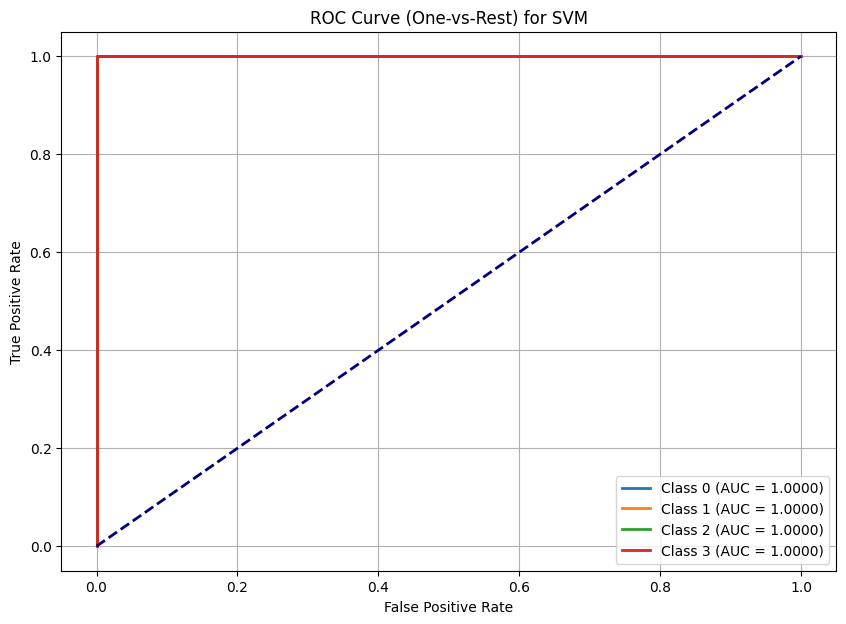

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_prob = svm.predict_proba(X_test)

plt.figure(figsize=(10, 7))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest) for SVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
